# RNA correlated boundary

In [1]:
import numpy as np
import pandas as pd
import cooler
import anndata
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
indir = '/data/hba/domain_majortype/'
outdir = '/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/'

In [4]:
# no L5ET
leg = ['L23_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_IT_Car3', 'L56_NP', 'L6_CT', 'L6b', 'Amy', 
       'Lamp5', 'Lamp5_LHX6', 'Sncg', 'Vip', 'Pvalb', 'Pvalb_ChC', 'Sst', 'CHD7', 
       'MSN_D1', 'MSN_D2', 'Foxp2', 'SubCtx', 
       # 'ASC', 'ODC', 'OPC', 'MGC', 'PC', 'EC', 'VLMC'
      ]
res = 25000


In [5]:
bound_count_ct = pd.read_hdf(f'{indir}MajorType_boundcount.hdf')
cell_count_ct = pd.read_csv(f'{indir}MajorType_cellcount.csv.gz', header=0, index_col=0)['count_cell']

In [6]:
bound_prob_ct = bound_count_ct.loc[leg] / cell_count_ct.loc[leg][:, None]


In [7]:
expr = pd.read_hdf('/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/cluster_expr.hdf').loc[leg]


In [8]:
from scipy.stats import rankdata

deg = np.zeros(expr.shape[1])
for i in range(len(leg)-1):
    for j in range(i+1, len(leg)):
        tmp = np.load(f'/home/jzhou_salk_edu/sky_workdir/hba/rna_majortype/DEG/{leg[i]}-{leg[j]}.npz')
        # deg[np.logical_and(np.abs(tmp['fc'])>1, tmp['fdr']<1e-3)] = 1
        rank = rankdata(tmp['fdr'])
        deg[rank<=100] = 1

print(deg.sum())


1131.0


In [11]:
chrom_size_path = f'/data/hba/loop_majortype/hg38_with_chrl.main.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)


In [19]:
gene_meta = pd.read_csv('/home/jzhou_salk_edu/sky_workdir/hba/ref/gencode.v33.bed', sep='\t', index_col=None, header=None)
gene_meta.columns = ['chrom', 'start', 'end', 'gene_id', 'gene_name', 'strand']
gene_meta = gene_meta.set_index('gene_id').loc[expr.columns[deg==1]]
gene_meta = gene_meta.loc[gene_meta['chrom'].isin(chrom_sizes.index[:22])]
gene_meta

,chrom,start,end,gene_name,strand
gene,,,,,
ENSG00000002746.15,chr7,43112629,43566001,HECW1,+
ENSG00000005108.16,chr7,11370365,11832198,THSD7A,-
ENSG00000006128.12,chr7,97732084,97740472,TAC1,+
ENSG00000006468.14,chr7,13891229,13991425,ETV1,-
ENSG00000007237.18,chr17,9910609,10198551,AC005747.1,-
...,...,...,...,...,...
ENSG00000286954.1,chr6,22663507,22675493,AL033539.2,+
ENSG00000287172.1,chr2,76185020,76399490,AC073091.3,+
ENSG00000287694.1,chr16,76277288,76819624,AC106741.2,+


In [9]:
binall = pd.DataFrame(index=bound_count_ct.columns)
binall['chrom'] = binall.index.str.split('_').str[0]
binall['start'] = binall.index.str.split('_').str[1].astype(int) * res
binall['end'] = binall['start'] + res
binall

,chrom,start,end
chr1_0,chr1,0,25000
chr1_1,chr1,25000,50000
chr1_2,chr1,50000,75000
chr1_3,chr1,75000,100000
chr1_4,chr1,100000,125000
...,...,...,...
chr22_2028,chr22,50700000,50725000
chr22_2029,chr22,50725000,50750000
chr22_2030,chr22,50750000,50775000
chr22_2031,chr22,50775000,50800000


In [10]:
import joblib
# from qnorm import quantile_normalize
from scipy.stats import norm
from statsmodels.sandbox.stats.multicomp import multipletests as FDR
from tqdm import tqdm
from ALLCools.mcds.correlation import corr_array


In [13]:
bkl = pd.read_csv(f'/data/hba/loop_majortype/M1C.rowsumpb1000.blf50.merged.bed', sep='\t', header=None, index_col=None)
binall['bklfilter'] = True
for c in chrom_sizes.index[:-1]:
    chrfilter = (binall['chrom']==c)
    tmp = binall.loc[chrfilter]
    tmp.iloc[:10, -1] = False
    tmp.iloc[-10:, -1] = False
    for xx,yy in bkl.loc[bkl[0]==c, [1,2]].values // res:
        tmp.iloc[max([0,xx-2]):(yy+2), -1] = False
    binall.loc[chrfilter] = tmp.copy()

print(binall['bklfilter'].sum())


100643


In [14]:
bound_prob_ct = bound_prob_ct.loc[:, binall['bklfilter']]
binall = binall.loc[binall['bklfilter']]


In [15]:
def shuffle_corr_norm(rna_data, dmr_data):
    
    shuffle_rna_data = rna_data.copy()
    for col, data in shuffle_rna_data.items():
        n_gene = shuffle_rna_data.shape[0]
        shuffle_rna_data[col] = shuffle_rna_data[col].sample(n_gene).values
    
    if dmr_data.shape[0] > 50000:
        shuffle_dmr_data = dmr_data.sample(50000).copy()
    else:
        shuffle_dmr_data = dmr_data.copy()
    for col, data in shuffle_dmr_data.items():
        n_dmr = shuffle_dmr_data.shape[0]
        shuffle_dmr_data[col] = shuffle_dmr_data[col].sample(n_dmr).values

    # shuffle corr
    shuffle_corr = corr_array(shuffle_rna_data, shuffle_dmr_data)
    mu, std = norm.fit(shuffle_corr.ravel())
    return mu, std, shuffle_corr.ravel()


In [16]:
null_mu, null_std, shuffle_corr = shuffle_corr_norm(expr.loc[:,  expr.columns.isin(gene_meta.index)].T, bound_prob_ct.T)
null_mu, null_std


(0.0019941576523659988, 0.2235632728434467)

In [17]:
shuffle_corr.shape

(54950000,)

In [20]:
gene_slop = 5000000


In [21]:
gene_records = []
for gene, row in tqdm(gene_meta.iterrows(), total=gene_meta.shape[0]):
    gene_rna = expr[[gene]].T
    
    dmr_chrom = row['chrom']
    dmr_start = row['start'] - gene_slop
    dmr_end = row['end'] + gene_slop
    sel_dmr = (binall['chrom']==dmr_chrom) & (binall['start'] > dmr_start) & (binall['start'] < dmr_end)
    gene_dmr = bound_prob_ct.T.loc[sel_dmr]

    gene_corr = corr_array(gene_rna, gene_dmr).ravel()
    gene_corr = pd.Series(gene_corr, index=gene_dmr.index)

    # pvalue = norm.sf(gene_corr.values, null_mu, null_std)
    # pvalue[pvalue > 0.5] = 1 - pvalue[pvalue > 0.5]
    # pvalue *= 2  # two tailed
    # perform multi-test correction and  q-value
    # _, q, *_ = fdrcorrection(pvalue)

    gene_corr.name = 'corr'
    gene_corr = gene_corr.reset_index()
    gene_corr['gene'] = gene
    # gene_corr["q"] = q
    
    # minimum filter
    # gene_corr = gene_corr[
    #     (gene_corr["q"] < min_q) & (gene_corr["corr"].abs() > min_corr)
    # ].set_index("dmr")

    # gene_records[gene] = gene_corr
    gene_records.append(gene_corr)
    

100%|██████████| 1099/1099 [00:21<00:00, 51.51it/s]


In [22]:
gene_records = pd.concat(gene_records, axis=0)
gene_records.index = np.arange(gene_records.shape[0])
gene_records

,index,corr,gene
0,chr7_1525,0.044345,ENSG00000002746.15
1,chr7_1526,-0.298720,ENSG00000002746.15
2,chr7_1527,-0.408159,ENSG00000002746.15
3,chr7_1528,-0.556742,ENSG00000002746.15
4,chr7_1529,-0.246539,ENSG00000002746.15
...,...,...,...
424261,chr11_3453,-0.259785,ENSG00000287912.1
424262,chr11_3454,-0.141301,ENSG00000287912.1
424263,chr11_3455,0.278937,ENSG00000287912.1
424264,chr11_3456,0.347317,ENSG00000287912.1


<AxesSubplot:ylabel='Density'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


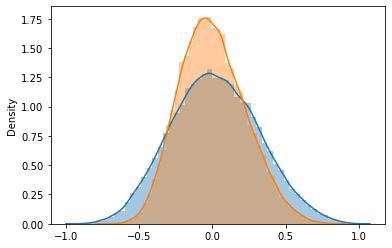

In [23]:
fig, ax = plt.subplots()
sns.distplot(np.random.choice(gene_records['corr'], 50000), ax=ax)
sns.distplot(np.random.choice(shuffle_corr, 50000), ax=ax)

In [24]:
t1 = rankdata(np.concatenate((gene_records['corr'].values, shuffle_corr)))[:gene_records.shape[0]]
t2 = rankdata(gene_records['corr'].values)


In [25]:
gene_records['FDRneg'] = (t1 - t2) / len(shuffle_corr) / t2 * gene_records.shape[0]
gene_records['FDRpos'] = (len(shuffle_corr) - t1 + t2) / len(shuffle_corr) / (gene_records.shape[0] - t2) * gene_records.shape[0]


In [26]:
threspos = gene_records.loc[gene_records['FDRpos']<0.1, 'corr'].min()
thresneg = gene_records.loc[gene_records['FDRneg']<0.1, 'corr'].max()
print(threspos, thresneg)


0.681722215979567 -0.514844193782862


In [27]:
gene_meta[['TSS', 'TES']] = gene_meta[['start', 'end']]
selg = (gene_meta['strand']=='-')
gene_meta.loc[selg, ['TSS', 'TES']] = gene_meta.loc[selg, ['TES', 'TSS']].values


In [28]:
gene_records['TSSdist'] = binall.loc[gene_records['index'], 'start'].values - gene_meta.loc[gene_records['gene'], 'TSS'].values
selg = (gene_meta.loc[gene_records['gene'], 'strand']=='-')
gene_records.loc[selg.values, 'TSSdist'] = -gene_records.loc[selg.values, 'TSSdist'].values

gene_records['TESdist'] = binall.loc[gene_records['index'], 'start'].values - gene_meta.loc[gene_records['gene'], 'TES'].values
selg = (gene_meta.loc[gene_records['gene'], 'strand']=='-')
gene_records.loc[selg.values, 'TESdist'] = -gene_records.loc[selg.values, 'TESdist'].values


In [29]:
gene_records['coord'] = 0
selp = (gene_records['TSSdist']<=0)
gene_records.loc[selp, 'coord'] = gene_records.loc[selp, 'TSSdist'] / res - 100

selp = (gene_records['TESdist']>=0)
gene_records.loc[selp, 'coord'] = gene_records.loc[selp, 'TESdist'] / res + 100

selp = (gene_records['TESdist']<0) & (gene_records['TSSdist']>0)
gene_records.loc[selp, 'coord'] = gene_records.loc[selp, 'TSSdist'] / (gene_records.loc[selp, 'TSSdist'] - gene_records.loc[selp, 'TESdist']) * 200 - 100


In [30]:
gene_records.to_hdf(f'{outdir}DEG_neu_bound_5M_corr.hdf', key='data')

In [4]:
gene_records = pd.read_hdf(f'{outdir}DEG_neu_bound_5M_corr.hdf', key='data')

In [31]:
thres = np.max(np.abs([thresneg, threspos]))
gene_records['group'] = gene_records['coord']//2
proppos = (gene_records.loc[gene_records['corr']>thres, 'group'].value_counts() / gene_records['group'].value_counts()).sort_index().fillna(0)
propneg = (gene_records.loc[gene_records['corr']<-thres, 'group'].value_counts() / gene_records['group'].value_counts()).sort_index().fillna(0)


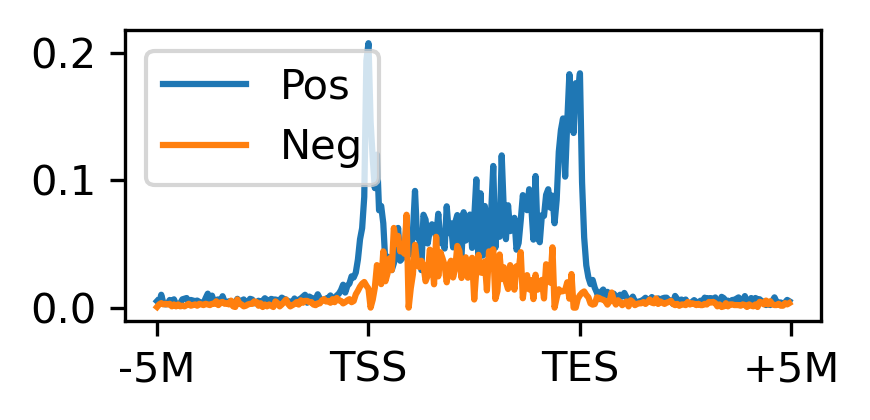

In [32]:
fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300)
ax.plot(np.arange(300), proppos, c='C0', label='Pos')
ax.plot(np.arange(300), propneg, c='C1', label='Neg')
ax.set_xticks([0, 100, 200, 300])
ax.set_xticklabels(['-5M', 'TSS', 'TES', '+5M'])
ax.legend()
plt.tight_layout()
# plt.savefig('proportion_corr_bound.pdf', transparent=True)


In [33]:
tmp = gene_records.loc[(gene_records['corr']>thres) & (gene_records['TSSdist']>-res) & (gene_records['TSSdist']<res), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_boundposcorr_tss.csv.gz', tmp, delimiter='\n', fmt='%s')

tmp = gene_records.loc[(gene_records['corr']>thres) & (gene_records['TESdist']>-res) & (gene_records['TESdist']<res), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_boundposcorr_tes.csv.gz', tmp, delimiter='\n', fmt='%s')

tmp = gene_records.loc[(gene_records['corr']>thres) & (((gene_records['TSSdist']>-res) & (gene_records['TSSdist']<res)) | ((gene_records['TESdist']>-res) & (gene_records['TESdist']<res))), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_boundposcorr_tsstes.csv.gz', tmp, delimiter='\n', fmt='%s')


285 0.25932666060054593
271 0.24658780709736125
466 0.4240218380345769


In [34]:
tmp = gene_records.loc[(gene_records['corr']>thres) & (gene_records['TSSdist']>-res) & (gene_records['TESdist']<res), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])
np.savetxt(f'{outdir}gene_boundposcorr_genebody.csv.gz', tmp, delimiter='\n', fmt='%s')

tmp = gene_records.loc[(gene_records['corr']<-thres) & (gene_records['TSSdist']>-res) & (gene_records['TESdist']<res), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])

tmp = gene_records.loc[(gene_records['corr'].abs()>thres) & (gene_records['TSSdist']>-res) & (gene_records['TESdist']<res), 'gene'].unique()
print(tmp.shape[0], tmp.shape[0]/gene_records['gene'].unique().shape[0])


591 0.5377616014558689
224 0.20382165605095542
674 0.6132848043676069


[Text(-300, 0, '-5M'),
 Text(-100, 0, 'TSS'),
 Text(100, 0, 'TES'),
 Text(300, 0, '+5M')]

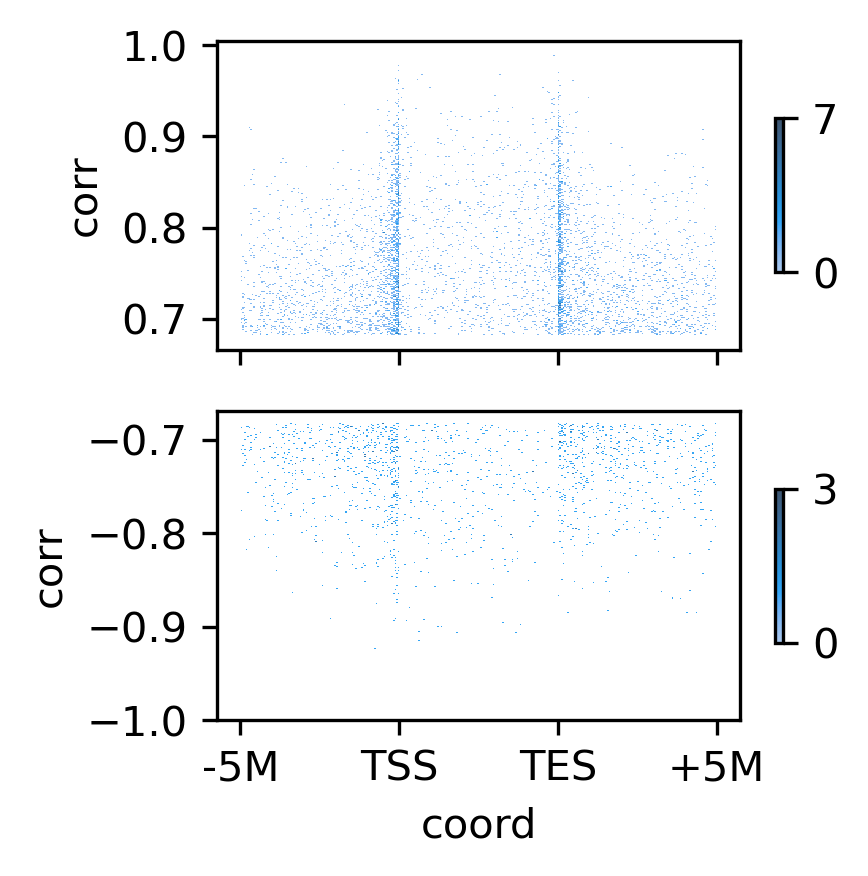

In [36]:
fig, axes = plt.subplots(2, 1, sharex='all', figsize=(3,3), dpi=300)
ax = axes[0]
tmp = gene_records.loc[gene_records['corr']>threspos]
sns.histplot(data=tmp, x='coord', y='corr', bins=300, ax=ax, cbar=True, cbar_kws=dict(ticks=[0,7], fraction=0.2, shrink=0.5))
ax.set_yticks([0.7, 0.8, 0.9, 1.0])

ax = axes[1]
# tmp = gene_records.loc[gene_records['corr']<thresneg]
tmp = gene_records.loc[gene_records['corr']<-threspos]
sns.histplot(data=tmp, x='coord', y='corr', bins=300, ax=ax, cbar=True, cbar_kws=dict(ticks=[0,3], fraction=0.2, shrink=0.5))
# ax.set_yticks([-0.6, -0.7, -0.8, -0.9])
ax.set_yticks([-0.7, -0.8, -0.9, -1.0])

ax.set_xticks([-300, -100, 100, 300])
ax.set_xticklabels(['-5M', 'TSS', 'TES', '+5M'])

# plt.savefig('DEG_domain_sigcorr.pdf', transparent=True)
